In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from typing import Literal, Optional
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langchain_core.messages import SystemMessage

from utils import show_graph
from prompts import BASE_PROMPT, PATIENT_INFO_ASKING_PROMPT, PATIENT_INFO_EXTRACTION_PROMPT

class AgentState(MessagesState):
    """State for the chatbot"""
    patient_name: str
    patient_age: int
    patient_sex: Literal["M", "F"]
    main_symptoms: list[str]
    symptom_onset: str
    associated_symptoms: list[str]
    additional_symptom_info: list[str]
    # medical_history: list[str]
    # urgency: Literal["low", "medium", "high"]


In [5]:
# Phase 1: Patient Information Collection
class PatientInfoPartial(BaseModel):
    name: Optional[str] = Field(description="The name of the patient")
    age: Optional[int] = Field(description="The age of the patient")
    sex: Optional[Literal["M", "F"]] = Field(description="The biological sex of the patient")
    
llm = init_chat_model(model="gpt-4.1", temperature=0)
extract_llm = llm.with_structured_output(PatientInfoPartial)

def ask_patient_info(state: AgentState) -> AgentState: 
    missing = []
    if state.get("patient_name") is None: missing.append("name")
    if state.get("patient_age") is None: missing.append("age")
    if state.get("patient_sex") is None: missing.append("sex")

    known_bits = []
    if state.get("patient_name") is not None: known_bits.append(f"name={state['patient_name']}")
    if state.get("patient_age") is not None: known_bits.append(f"age={state['patient_age']}")
    if state.get("patient_sex") is not None: known_bits.append(f"sex={state['patient_sex']}")

    steering = (
        "You are collecting basic patient demographic information for triage.\n"
        f"Known so far: {', '.join(known_bits) if known_bits else 'none'}.\n"
        f"Missing (in order): {', '.join(missing) if missing else 'none'}.\n"
        "- If anything is missing, ask ONLY for the first missing field with one concise question.\n"
        "- Keep it friendly and brief."
    )

    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=PATIENT_INFO_ASKING_PROMPT),
        SystemMessage(content=steering),
        *state["messages"],
    ]
    resp = llm.invoke(msgs)

    return {"messages": [resp]}

def extract_patient_info(state: AgentState) -> AgentState:
    human_only = [m for m in state.get("messages", []) if isinstance(m, HumanMessage)]
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=(
            PATIENT_INFO_EXTRACTION_PROMPT +
            "\nOnly extract info stated by the patient. If not present, leave that field null. Use the right capitalization for names (eg. Jon Ang instead of jon ang)."
        )),
        *human_only,
    ]
    parsed: PatientInfoPartial = extract_llm.invoke(msgs)

    updates = {}
    if parsed.name is not None and state.get("patient_name") is None:
        updates["patient_name"] = parsed.name
    if parsed.age is not None and state.get("patient_age") is None:
        updates["patient_age"] = parsed.age
    if parsed.sex is not None and state.get("patient_sex") is None:
        updates["patient_sex"] = parsed.sex
    return updates


patient_demo_builder = StateGraph(AgentState)
patient_demo_builder.add_node("collect_patient_info", extract_patient_info)
patient_demo_builder.add_node("ask_patient_info", ask_patient_info)

patient_demo_builder.add_edge(START, "ask_patient_info")
patient_demo_builder.add_edge("ask_patient_info", "collect_patient_info")
patient_demo_builder.add_edge("collect_patient_info", END)

patient_demo_graph = patient_demo_builder.compile()


C:\Users\user\AppData\Local\Temp\ipykernel_141140\1124964412.py:7: LangChainBetaWarning: The function `init_chat_model` is in beta. It is actively being worked on, so the API may change.
  llm = init_chat_model(model="gpt-4.1", temperature=0)


In [6]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
patient_demo_graph = patient_demo_builder.compile(checkpointer=checkpointer)

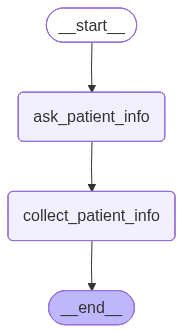

In [7]:
show_graph(patient_demo_graph)

In [8]:
from langchain_core.messages import HumanMessage, AIMessage

state = {
    "messages": [],
    "patient_name": None,
    "patient_age": None,
    "patient_sex": None,
}

config = {"configurable": {"thread_id": "1"}}

last_ai_key = None 

# Initial invoke
for event in patient_demo_graph.stream({"messages": []}, config, stream_mode="values"):
    msgs = event.get("messages", [])
    if not msgs:
        continue
    last = msgs[-1]
    if isinstance(last, AIMessage):
        key = getattr(last, "id", None) or (last.content, len(msgs))
        if key != last_ai_key:
            print("Assistant:", last.content)
            last_ai_key = key

def is_complete(state: dict) -> bool:
    return state.get("patient_name") is not None and state.get("patient_age") is not None and state.get("patient_sex") is not None

# Loop
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    for event in patient_demo_graph.stream({"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"):
        msgs = event.get("messages", [])
        if not msgs:
            continue
        last = msgs[-1]
        if isinstance(last, AIMessage):
            key = getattr(last, "id", None) or (last.content, len(msgs))
            if key != last_ai_key:
                print("Assistant:", last.content)
                last_ai_key = key
    
    # Check state
    snapshot = patient_demo_graph.get_state(config)
    if is_complete(snapshot.values):
        s = snapshot.values
        print(f"\n✓ Complete! Name: {s['patient_name']}, Age: {s['patient_age']}, Sex: {s['patient_sex']}")
        break

checkpointer.delete_thread("1")

Assistant: Hi, welcome to ClinicAssist. How can I help you today? To get started, may I have your name, please?
Assistant: Thank you, Wang Junwei. Could you please tell me your age?
Assistant: Thank you. Could you please confirm your sex (male, female, or other)?
Assistant: Thank you for providing your information, Wang Junwei.

Now, let's move on to your symptoms. What brings you to the clinic today? Are you experiencing any specific symptoms or concerns?

✓ Complete! Name: wang junwei, Age: 23, Sex: M


In [9]:
from prompts import BASE_PROMPT, SYMPTOMS_ASKING_PROMPT, SYMPTOMS_EXTRACTION_PROMPT, SYMPTOMS_SUFFICIENCY_CHECK_PROMPT
from datetime import datetime

def get_current_time():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Phase 2: Symptoms Collection
class SymptomsPartial(BaseModel):
    main_symptoms: Optional[list[str]] = Field(description="Primary symptom(s) patient is experiencing")
    symptom_onset: Optional[str] = Field(description="When symptoms started (e.g., '3 days ago', 'this morning')")
    associated_symptoms: Optional[list[str]] = Field(description="Related or secondary symptoms")
    additional_symptom_info: Optional[list[str]] = Field(description="Other relevant details: severity, triggers, alleviating factors etc.")

class SymptomSufficiencyCheck(BaseModel):
    is_sufficient: bool = Field(description="Whether the information provided is sufficient for first assessment by doctor")
    reason: Optional[str] = Field(description="Why more info is needed, or None if sufficient")

symptoms_llm = llm.with_structured_output(SymptomsPartial)
symptom_sufficiency_llm = llm.with_structured_output(SymptomSufficiencyCheck)

def ask_symptoms(state: AgentState) -> AgentState:
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=SYMPTOMS_ASKING_PROMPT.format(current_time=get_current_time())),
        *state["messages"],
    ]
    resp = llm.invoke(msgs)
    return {"messages": [resp]}

def extract_symptoms(state: AgentState) -> AgentState:
    extracted_symptoms = {
        "main_symptoms": state.get("main_symptoms"),
        "symptom_onset": state.get("symptom_onset"),
        "associated_symptoms": state.get("associated_symptoms"),
        "additional_symptom_info": state.get("additional_symptom_info")
    }
    human_only = [m for m in state.get("messages", []) if isinstance(m, HumanMessage)]
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=(
            SYMPTOMS_EXTRACTION_PROMPT.format(current_time=get_current_time(), extracted_symptoms=extracted_symptoms) +
            "\nOnly extract info stated by the patient."
        )),
        *human_only,
    ]
    parsed: SymptomsPartial = symptoms_llm.invoke(msgs)
    updates = {}
    if parsed.main_symptoms is not None and state.get("main_symptoms") is None:
        updates["main_symptoms"] = parsed.main_symptoms
    if parsed.symptom_onset is not None and state.get("symptom_onset") is None:
        updates["symptom_onset"] = parsed.symptom_onset
    if parsed.associated_symptoms is not None and state.get("associated_symptoms") is None:
        updates["associated_symptoms"] = parsed.associated_symptoms
    if parsed.additional_symptom_info is not None and state.get("additional_symptom_info") is None:
        updates["additional_symptom_info"] = parsed.additional_symptom_info
    return updates

def check_symptom_sufficiency(dict: dict):
    msgs = [
        SystemMessage(content=BASE_PROMPT),
        SystemMessage(content=SYMPTOMS_SUFFICIENCY_CHECK_PROMPT),
        *dict["messages"],
    ]
    resp = symptom_sufficiency_llm.invoke(msgs)
    
    return resp

def should_continue(dict: dict):
    has_main = dict.get("main_symptoms") and len(dict["main_symptoms"]) > 0
    has_onset = dict.get("symptom_onset") is not None

    if not (has_main and has_onset):
        return False
    
    check = check_symptom_sufficiency(dict)
    return check.is_sufficient

symptoms_builder = StateGraph(AgentState)
symptoms_builder.add_node("ask_symptoms", ask_symptoms)
symptoms_builder.add_node("extract_symptoms", extract_symptoms)

symptoms_builder.add_edge(START, "ask_symptoms")
symptoms_builder.add_edge("ask_symptoms", "extract_symptoms")
symptoms_builder.add_edge("extract_symptoms", END)

symptoms_graph = symptoms_builder.compile()

In [10]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
symptoms_graph = symptoms_builder.compile(checkpointer=checkpointer)

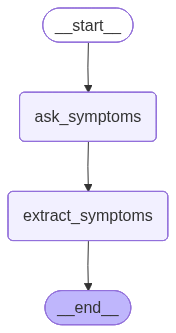

In [11]:
show_graph(symptoms_graph)

In [12]:
from langchain_core.messages import HumanMessage, AIMessage

state = {
    "messages": [],
    "main_symptoms": None,
    "symptom_onset": None,
    "associated_symptoms": None,
    "additional_symptom_info": None,
}

config = {"configurable": {"thread_id": "1"}}

last_ai_key = None 

# Initial invoke
for event in symptoms_graph.stream({"messages": []}, config, stream_mode="values"):
    msgs = event.get("messages", [])
    if not msgs:
        continue
    last = msgs[-1]
    if isinstance(last, AIMessage):
        key = getattr(last, "id", None) or (last.content, len(msgs))
        if key != last_ai_key:
            print("Assistant:", last.content)
            last_ai_key = key

# Loop
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    
    for event in symptoms_graph.stream({"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"):
        msgs = event.get("messages", [])
        if not msgs:
            continue
        last = msgs[-1]
        if isinstance(last, AIMessage):
            key = getattr(last, "id", None) or (last.content, len(msgs))
            if key != last_ai_key:
                print("Assistant:", last.content)
                last_ai_key = key
    
    # Check state
    snapshot = symptoms_graph.get_state(config)
    if should_continue(snapshot.values):
        s = snapshot.values
        print(f"\n✓ Complete! Main Symptoms: {s['main_symptoms']}\n Symptom Onset: {s['symptom_onset']}\n Associated Symptoms: {s['associated_symptoms']}\n Additional Symptom Info: {s['additional_symptom_info']}")
        break

checkpointer.delete_thread("1")

Assistant: Thank you for providing your demographic information. Now, can you please tell me what symptoms or health concerns brought you to the clinic today?
Assistant: Thank you for sharing that. Can you tell me when your fever and headache started? Did they begin at the same time, or did one start before the other?
Assistant: Thank you for clarifying. Have you measured your temperature? If so, what was the highest reading you noticed?
Assistant: Thank you. Besides fever and headache, are you experiencing any other symptoms, such as cough, sore throat, runny nose, body aches, nausea, vomiting, or diarrhea?
Assistant: Thank you for letting me know. Can you describe the body aches a bit more? For example, are they mild or severe, and are they located in any specific part of your body or all over?
Assistant: Thank you for describing that. Have you noticed any other symptoms, such as chills, sweating, fatigue, or difficulty breathing?
Assistant: Thank you for your response. Just to confi